### Preprocessing and Model Setup

The following code snippet demonstrates:
- Checking for GPU availability to accelerate computations.
- Loading and preprocessing the dataset for SITS-BERT.
- Normalizing reflectance values and reshaping the data to the required format.


In [ ]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    print("GPU is available! Using GPU.")
else:
    device = torch.device("cpu")   # Use CPU
    print("GPU is not available. Using CPU.")

GPU is available! Using GPU.


In [ ]:
import numpy as np
import pandas as pd

# Load your dataset
data = pd.read_csv("/kaggle/input/dataset/combined_data.csv")

# Replace NaN values with 0 (or interpolate if preferred)
data = data.fillna(0)

In [ ]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,441,442,443,444,445,446,447,448,449,450
0,808,647,487,459,446,463,464,518,433,532,...,272.0,277.0,282.0,287.0,297.0,302.0,307.0,312.0,322.0,327.0
1,696,618,622,418,620,426,473,509,1098,601,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,520,447,385,344,379,323,380,454,415,458,...,272.0,277.0,282.0,287.0,297.0,302.0,307.0,312.0,322.0,327.0
3,679,702,598,660,702,764,878,952,905,997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,534,397,459,648,838,863,659,1005,856,935,...,262.0,267.0,272.0,277.0,282.0,287.0,297.0,302.0,307.0,362.0


In [ ]:
# Drop the first column (index column)
data = data.iloc[:, 1:]

In [ ]:
print(data.shape)

(315171, 450)


In [ ]:
# Reshape the data into (num_samples, num_timesteps, num_bands)
num_samples = data.shape[0]
num_timesteps = 45  # Number of time steps (45 images)
num_bands = 10      # Number of spectral bands (Sentinel-2)

In [ ]:
# Reshape the data
reshaped_data = data.values.reshape(num_samples, num_timesteps, num_bands)

In [ ]:
# Normalize spectral data to [0, 1]
reshaped_data = reshaped_data / 10000.0

In [ ]:
# Generate synthetic acquisition dates (DOY)
doy = np.arange(1, num_timesteps + 1)
doy = np.tile(doy, (num_samples, 1))

# Save the preprocessed data
np.save("/kaggle/working/preprocessed_data.npy", reshaped_data)
np.save("/kaggle/working/doy.npy", doy)

### Observation Embedding and Model Architecture

This section introduces the **Observation Embedding** and the **Transformer Encoder** components, which form the backbone of the SITS-BERT model. The Observation Embedding combines spectral embeddings and positional encoding to represent satellite images at each time step, while the Transformer Encoder captures long-range temporal dependencies in the data.

The code snippet below defines:
- The `ObservationEmbedding` class for embedding spectral data and temporal features.
- The `TransformerEncoder` class for modeling sequential relationships.
- The complete SITS-BERT model that integrates these components.


In [ ]:
import torch
import torch.nn as nn

class ObservationEmbedding(nn.Module):
    def __init__(self, input_dim, embed_dim):
        super(ObservationEmbedding, self).__init__()
        self.embed_dim = embed_dim
        self.spectral_embed = nn.Linear(input_dim, embed_dim // 2)
        self.positional_encoding = self._generate_positional_encoding()

    def _generate_positional_encoding(self):
        # Generate positional encoding using sine and cosine functions
        position = torch.arange(0, 366).unsqueeze(1)  # Day of year (DOY)
        div_term = torch.exp(torch.arange(0, self.embed_dim // 2, 2) * -(torch.log(torch.tensor(10000.0)) / (self.embed_dim // 2)))
        pe = torch.zeros(366, self.embed_dim // 2)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

    def forward(self, spectral_data, doy):
        # Move positional encoding to the same device as the input
        pe = self.positional_encoding.to(spectral_data.device)

        # Spectral embedding
        spectral_embed = self.spectral_embed(spectral_data)

        # Positional encoding
        pe = pe[doy.long()]

        # Concatenate spectral and positional embeddings
        embed = torch.cat([spectral_embed, pe], dim=-1)
        return embed

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, ff_dim):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        return self.transformer(x)

class SITSBERT(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, ff_dim):
        super(SITSBERT, self).__init__()
        self.embedding = ObservationEmbedding(input_dim, embed_dim)
        self.transformer = TransformerEncoder(embed_dim, num_heads, num_layers, ff_dim)
        self.output_layer = nn.Linear(embed_dim, input_dim)  # Predict original spectral values

    def forward(self, spectral_data, doy):
        embed = self.embedding(spectral_data, doy)
        transformer_output = self.transformer(embed)
        output = self.output_layer(transformer_output)
        return output

In [ ]:
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Initialize the model and move it to GPU
model = SITSBERT(input_dim=10, embed_dim=256, num_heads=8, num_layers=6, ff_dim=512)
model.to(device)

# Load preprocessed data
spectral_data = torch.tensor(np.load("/kaggle/working/preprocessed_data.npy"), dtype=torch.float32)
doy = torch.tensor(np.load("/kaggle/working/doy.npy"), dtype=torch.long)

# Move data to GPU
spectral_data = spectral_data.to(device)
doy = doy.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


### Pretraining the SITS-BERT Model

The pretraining phase helps the model learn a generalized understanding of the temporal and spectral patterns in the data. We use a large dataset of unlabeled satellite images for this purpose. Noise is added to the input data to encourage robustness, and the model learns to predict the original spectral values.

The code below outlines:
- The pretraining loop with GPU-accelerated data handling.
- Noise injection to the input data for training.
- Validation loss evaluation and model checkpointing for the best results.


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

class DataSetWrapper:
    def __init__(self, batch_size, valid_size, data_path, num_features, max_length):
        self.batch_size = batch_size
        self.valid_size = valid_size
        self.data_path = data_path
        self.num_features = num_features
        self.max_length = max_length

    def get_data_loaders(self):
        # Load preprocessed data
        spectral_data = torch.tensor(np.load("/kaggle/working/preprocessed_data.npy"), dtype=torch.float32)
        doy = torch.tensor(np.load("/kaggle/working/doy.npy"), dtype=torch.long)

        # Create a dataset
        dataset = TensorDataset(spectral_data, doy)

        # Split into training and validation sets
        num_train = len(dataset)
        indices = list(range(num_train))
        np.random.shuffle(indices)

        split = int(np.floor(self.valid_size * num_train))
        train_idx, valid_idx = indices[split:], indices[:split]

        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        # Create DataLoaders
        train_loader = DataLoader(dataset, batch_size=self.batch_size, sampler=train_sampler, drop_last=True)
        valid_loader = DataLoader(dataset, batch_size=self.batch_size, sampler=valid_sampler, drop_last=True)

        return train_loader, valid_loader

In [ ]:
import torch.optim as optim
from tqdm import tqdm

# Initialize the DataSetWrapper
dataset_wrapper = DataSetWrapper(batch_size=256, valid_size=0.03, data_path="/kaggle/working/", num_features=10, max_length=64)
train_loader, valid_loader = dataset_wrapper.get_data_loaders()

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()  # Mean-squared error loss

# Pretraining loop with validation evaluation
num_epochs = 30
best_val_loss = float('inf')  # Track the best validation loss

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # Training loop
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
    for batch in progress_bar:
        spectral_data, doy = batch

        # Move data to GPU
        spectral_data = spectral_data.to(device)
        doy = doy.to(device)

        # Add noise to the spectral data
        noise = torch.rand_like(spectral_data) * 0.1  # Uniform noise in [0, 0.1]
        noisy_spectral_data = spectral_data + noise

        # Forward pass
        predictions = model(noisy_spectral_data, doy)

        # Compute loss
        loss = criterion(predictions, spectral_data)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        train_loss += loss.item()

        # Update the progress bar description with the current loss
        progress_bar.set_postfix({"Train Loss": loss.item()})

    # Calculate average training loss
    train_loss /= len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        progress_bar = tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Validation]", leave=False)
        for batch in progress_bar:
            spectral_data, doy = batch

            # Move data to GPU
            spectral_data = spectral_data.to(device)
            doy = doy.to(device)

            # Add noise to the spectral data
            noise = torch.rand_like(spectral_data) * 0.1  # Uniform noise in [0, 0.1]
            noisy_spectral_data = spectral_data + noise

            # Forward pass
            predictions = model(noisy_spectral_data, doy)

            # Compute loss
            loss = criterion(predictions, spectral_data)

            # Accumulate validation loss
            val_loss += loss.item()

            # Update the progress bar description with the current loss
            progress_bar.set_postfix({"Val Loss": loss.item()})

    # Calculate average validation loss
    val_loss /= len(valid_loader)

    # Print epoch results
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}")

    # Save the model if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/kaggle/working/pretrained_sits_bert.pth")
        print(f"Model saved with Val Loss: {val_loss}")

Epoch 1/30, Train Loss: 0.00435574773289154, Val Loss: 0.000708769486259876
Model saved with Val Loss: 0.000708769486259876


Epoch 2/30, Train Loss: 0.0009512338885110047, Val Loss: 0.0005129460154825614
Model saved with Val Loss: 0.0005129460154825614


Epoch 3/30, Train Loss: 0.0006547958345462098, Val Loss: 0.0004229558827420179
Model saved with Val Loss: 0.0004229558827420179


Epoch 4/30, Train Loss: 0.0005274715315298235, Val Loss: 0.00039206974826002907
Model saved with Val Loss: 0.00039206974826002907


Epoch 5/30, Train Loss: 0.00045658109361642013, Val Loss: 0.00035681315704197105
Model saved with Val Loss: 0.00035681315704197105


Epoch 6/30, Train Loss: 0.000409775418910928, Val Loss: 0.0003317649017036375
Model saved with Val Loss: 0.0003317649017036375


Epoch 7/30, Train Loss: 0.0003794176264945262, Val Loss: 0.0003309549930337299
Model saved with Val Loss: 0.0003309549930337299


Epoch 8/30, Train Loss: 0.00035576959431832077, Val Loss: 0.0003208196228822797
Model saved with Val Loss: 0.0003208196228822797


Epoch 9/30, Train Loss: 0.00033980241080748395, Val Loss: 0.0003008981075254269
Model saved with Val Loss: 0.0003008981075254269


Epoch 10/30, Train Loss: 0.0003274117113187382, Val Loss: 0.00029388139308947656
Model saved with Val Loss: 0.00029388139308947656


Epoch 11/30, Train Loss: 0.0003179127622816565, Val Loss: 0.0002917491049932626
Model saved with Val Loss: 0.0002917491049932626


Epoch 12/30, Train Loss: 0.0003091936131609351, Val Loss: 0.00028297259672803595
Model saved with Val Loss: 0.00028297259672803595


Epoch 13/30, Train Loss: 0.00030216007773067107, Val Loss: 0.00028099685328521044
Model saved with Val Loss: 0.00028099685328521044


Epoch 14/30, Train Loss: 0.00029623382972959755, Val Loss: 0.00027474352181242366
Model saved with Val Loss: 0.00027474352181242366


Epoch 15/30, Train Loss: 0.0002909224655208532, Val Loss: 0.00027135540504888113
Model saved with Val Loss: 0.00027135540504888113


Epoch 16/30, Train Loss: 0.00028663833702249853, Val Loss: 0.00026945846184389666
Model saved with Val Loss: 0.00026945846184389666


Epoch 17/30, Train Loss: 0.00028311081987827507, Val Loss: 0.00026698378496803343
Model saved with Val Loss: 0.00026698378496803343


Epoch 18/30, Train Loss: 0.0002801269414950509, Val Loss: 0.00026553545063102827
Model saved with Val Loss: 0.00026553545063102827


Epoch 19/30, Train Loss: 0.0002776527573246122, Val Loss: 0.00026487770810490474
Model saved with Val Loss: 0.00026487770810490474


Epoch 20/30, Train Loss: 0.00027554448350009756, Val Loss: 0.00026298483296866633
Model saved with Val Loss: 0.00026298483296866633


Epoch 21/30, Train Loss: 0.00027381663088912184, Val Loss: 0.0002650712550449599


Epoch 22/30, Train Loss: 0.0002724344699931763, Val Loss: 0.0002608979048090987
Model saved with Val Loss: 0.0002608979048090987


Epoch 23/30, Train Loss: 0.00027084947706838223, Val Loss: 0.00025935144771614834
Model saved with Val Loss: 0.00025935144771614834


Epoch 24/30, Train Loss: 0.0002698076740377216, Val Loss: 0.0002599272548751388


Epoch 25/30, Train Loss: 0.0002684611116358121, Val Loss: 0.0002595981374421778


Epoch 26/30, Train Loss: 0.00026751113129993025, Val Loss: 0.0002589505582161817
Model saved with Val Loss: 0.0002589505582161817


Epoch 27/30, Train Loss: 0.0002666328736491988, Val Loss: 0.00025784183203035756
Model saved with Val Loss: 0.00025784183203035756


Epoch 28/30, Train Loss: 0.0002657047570662587, Val Loss: 0.00025650720110408857
Model saved with Val Loss: 0.00025650720110408857


Epoch 29/30, Train Loss: 0.0002648437356106762, Val Loss: 0.00025702986992352333


Epoch 30/30, Train Loss: 0.0002642026196145788, Val Loss: 0.00025537663087662723
Model saved with Val Loss: 0.00025537663087662723


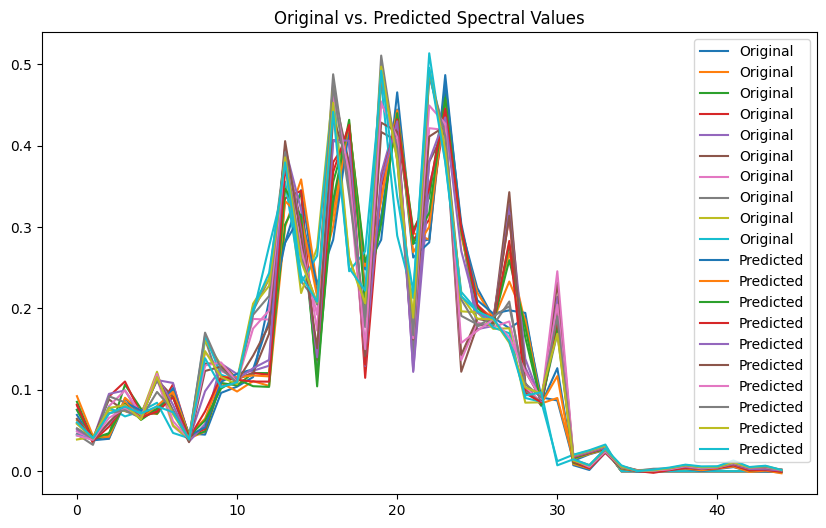

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of data
spectral_data, doy = next(iter(valid_loader))
spectral_data = spectral_data.to(device)
doy = doy.to(device)

# Add noise
noise = torch.rand_like(spectral_data) * 0.1
noisy_spectral_data = spectral_data + noise

# Get predictions
with torch.no_grad():
    predictions = model(noisy_spectral_data, doy)

# Plot the first sample in the batch
plt.figure(figsize=(10, 6))
plt.plot(spectral_data[0].cpu().numpy(), label="Original")
plt.plot(predictions[0].cpu().numpy(), label="Predicted")
plt.legend()
plt.title("Original vs. Predicted Spectral Values")
plt.show()

### Pretraining Summary

- **Training Loss**: Observed a steady reduction in training loss across epochs, indicating effective learning.
- **Validation Loss**: Monitored to ensure generalization and avoid overfitting.
- **Checkpointing**: Saved the best-performing model for subsequent fine-tuning.

With the pretrained SITS-BERT model, we are ready to fine-tune it on labeled datasets for specific classification tasks.


### Fine-tuning the SITS-BERT Model

After pretraining, the model is fine-tuned on labeled satellite image datasets for specific classification tasks, such as land cover classification or crop monitoring. During fine-tuning:
- The model is updated to predict class labels rather than reconstruct spectral values.
- Training and validation datasets are used to optimize the classification accuracy.
- Metrics like Overall Accuracy (OA), Kappa Coefficient, and Average Accuracy (AA) are monitored to evaluate performance.

The following code defines:
- A fine-tuning dataset wrapper and dataloaders.
- The fine-tuning loop with metrics computation.
- Saving and loading checkpoints for the best-performing models.


In [ ]:
# Load the pretrained SITSBERT model
model = SITSBERT(input_dim=10, embed_dim=256, num_heads=8, num_layers=6, ff_dim=512)
model.load_state_dict(torch.load("/kaggle/working/pretrained_sits_bert.pth"))
model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-17-daddd1274536>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you sta

SITSBERT(
  (embedding): ObservationEmbedding(
    (spectral_embed): Linear(in_features=10, out_features=128, bias=True)
  )
  (transformer): TransformerEncoder(
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
from torch.utils.data import Dataset
import torch
import numpy as np

class FinetuneDataset(Dataset):
    def __init__(self, file_path, feature_num, seq_len):
        """
        :param file_path: Path to the labeled dataset file (e.g., Train.csv, Validate.csv, Test.csv).
        :param feature_num: Number of input features (e.g., 10 for Sentinel-2 spectral bands).
        :param seq_len: Padded sequence length (e.g., 45 for 45 time steps).
        """
        self.seq_len = seq_len
        self.dimension = feature_num

        with open(file_path, 'r') as ifile:
            self.Data = ifile.readlines()
            self.TS_num = len(self.Data)

    def __len__(self):
        return self.TS_num

    def __getitem__(self, item):
        line = self.Data[item]

        # Remove the newline character and split the data
        line_data = line[:-1].split(',')
        line_data = list(map(float, line_data))
        line_data = np.array(line_data, dtype=float)

        # Extract the class label (last value in the line)
        class_label = np.array([line_data[-1]], dtype=int)

        # Reshape the data into (time steps, features + 1)
        ts = np.reshape(line_data[:-1], (self.dimension + 1, -1)).T
        ts_length = ts.shape[0]

        # Create a mask for the sequence
        bert_mask = np.zeros((self.seq_len,), dtype=int)
        bert_mask[:ts_length] = 1

        # Normalize spectral data (reflectance values)
        ts_origin = np.zeros((self.seq_len, self.dimension))
        ts_origin[:ts_length, :] = ts[:, :-1] / 10000.0

        # Extract day of year (DOY)
        doy = np.zeros((self.seq_len,), dtype=int)
        doy[:ts_length] = np.squeeze(ts[:, -1])

        # Prepare the output dictionary
        output = {
            "bert_input": ts_origin,
            "bert_mask": bert_mask,
            "class_label": class_label,
            "time": doy,
        }

        # Convert numpy arrays to PyTorch tensors
        return {key: torch.from_numpy(value) for key, value in output.items()}

In [ ]:
from torch.utils.data import DataLoader

# Define paths to your labeled dataset
train_file = "/kaggle/input/finetuningdata/California-Labeled/Train.csv"
valid_file = "/kaggle/input/finetuningdata/California-Labeled/Validate.csv"
test_file = "/kaggle/input/finetuningdata/California-Labeled/Test.csv"

# Create datasets
train_dataset = FinetuneDataset(train_file, feature_num=10, seq_len=45)
valid_dataset = FinetuneDataset(valid_file, feature_num=10, seq_len=45)
test_dataset = FinetuneDataset(test_file, feature_num=10, seq_len=45)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False)

In [ ]:
import torch.nn as nn

class SITSBERTClassification(nn.Module):
    def __init__(self, sbert, num_classes):
        super().__init__()
        self.sbert = sbert
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, spectral_data, doy, mask):
        # Get embeddings from SITSBERT
        embed = self.sbert.embedding(spectral_data, doy)
        transformer_output = self.sbert.transformer(embed)

        # Pooling over the time dimension (mean pooling)
        cls_output = transformer_output.mean(dim=1)

        # Classification
        logits = self.classifier(cls_output)
        return logits

In [ ]:
import numpy as np

def kappa(matrix):
    n = np.sum(matrix)
    sum_po = 0
    sum_pe = 0
    for i in range(len(matrix[0])):
        sum_po += matrix[i][i]
        row = np.sum(matrix[i, :])
        col = np.sum(matrix[:, i])
        sum_pe += row * col
    po = sum_po / n
    pe = sum_pe / (n * n)
    return (po - pe) / (1 - pe)

def average_accuracy(matrix):
    correct = np.diag(matrix)
    all = matrix.sum(axis=0)
    accuracy = correct / all
    aa = np.average(accuracy)
    return aa

In [ ]:
from torch.optim import Adam

class SITSBERTFineTuner:
    def __init__(self, sbert, num_classes, train_dataloader, valid_dataloader, lr=1e-4):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.sbert = sbert
        self.model = SITSBERTClassification(sbert, num_classes).to(self.device)
        self.num_classes = num_classes

        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader

        self.optim = Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()

    def train(self, epoch):
        self.model.train()
        train_loss = 0.0
        total_correct = 0
        total_element = 0
        matrix = np.zeros([self.num_classes, self.num_classes])

        for data in self.train_dataloader:
            data = {key: value.to(self.device) for key, value in data.items()}

            # Forward pass
            classification = self.model(data["bert_input"].float(),
                                       data["time"].long(),
                                       data["bert_mask"].long())

            # Compute loss
            loss = self.criterion(classification, data["class_label"].squeeze().long())
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()

            # Accumulate loss and accuracy
            train_loss += loss.item()
            classification_result = classification.argmax(dim=-1)
            classification_target = data["class_label"].squeeze()
            correct = classification_result.eq(classification_target).sum().item()
            total_correct += correct
            total_element += data["class_label"].nelement()

            # Update confusion matrix
            for row, col in zip(classification_result, classification_target):
                matrix[row, col] += 1

        # Calculate metrics
        train_loss /= len(self.train_dataloader)
        train_OA = total_correct / total_element * 100
        train_kappa = kappa(matrix)  # Use the kappa function

        # Validate
        valid_loss, valid_OA, valid_kappa = self._validate()

        # Print results
        print(f"EP{epoch}, train_OA={train_OA:.2f}, train_Kappa={train_kappa:.3f}, "
              f"validate_OA={valid_OA:.2f}, validate_Kappa={valid_kappa:.3f}")

        return train_OA, train_kappa, valid_OA, valid_kappa

    def _validate(self):
        self.model.eval()
        valid_loss = 0.0
        total_correct = 0
        total_element = 0
        matrix = np.zeros([self.num_classes, self.num_classes])

        with torch.no_grad():
            for data in self.valid_dataloader:
                data = {key: value.to(self.device) for key, value in data.items()}

                # Forward pass
                classification = self.model(data["bert_input"].float(),
                                           data["time"].long(),
                                           data["bert_mask"].long())

                # Compute loss
                loss = self.criterion(classification, data["class_label"].squeeze().long())
                valid_loss += loss.item()

                # Calculate accuracy
                classification_result = classification.argmax(dim=-1)
                classification_target = data["class_label"].squeeze()
                correct = classification_result.eq(classification_target).sum().item()
                total_correct += correct
                total_element += data["class_label"].nelement()

                # Update confusion matrix
                for row, col in zip(classification_result, classification_target):
                    matrix[row, col] += 1

        # Calculate metrics
        valid_loss /= len(self.valid_dataloader)
        valid_OA = total_correct / total_element * 100
        valid_kappa = kappa(matrix)  # Use the kappa function

        self.model.train()
        return valid_loss, valid_OA, valid_kappa

    def test(self, data_loader):
        self.model.eval()
        total_correct = 0
        total_element = 0
        matrix = np.zeros([self.num_classes, self.num_classes])

        with torch.no_grad():
            for data in data_loader:
                data = {key: value.to(self.device) for key, value in data.items()}

                # Forward pass
                result = self.model(data["bert_input"].float(),
                                   data["time"].long(),
                                   data["bert_mask"].long())

                # Calculate accuracy
                classification_result = result.argmax(dim=-1)
                classification_target = data["class_label"].squeeze()
                correct = classification_result.eq(classification_target).sum().item()
                total_correct += correct
                total_element += data["class_label"].nelement()

                # Update confusion matrix
                for row, col in zip(classification_result, classification_target):
                    matrix[row, col] += 1

        # Calculate metrics
        test_OA = total_correct * 100.0 / total_element
        test_kappa = kappa(matrix)  # Use the kappa function
        test_AA = average_accuracy(matrix)  # Use the average_accuracy function

        self.model.train()
        return test_OA, test_kappa, test_AA, matrix

    def save(self, epoch, file_path):
        output_path = file_path + "checkpoint.tar"
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optim.state_dict(),
        }, output_path)
        print(f"EP:{epoch} Model Saved on: {output_path}")

    def load(self, file_path):
        input_path = file_path + "checkpoint.tar"
        checkpoint = torch.load(input_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optim.load_state_dict(checkpoint['optimizer_state_dict'])
        self.model.train()
        epoch = checkpoint['epoch']
        print(f"EP:{epoch} Model Loaded from: {input_path}")

In [ ]:
# Initialize the fine-tuner
trainer = SITSBERTFineTuner(sbert, num_classes=13,  # Adjust num_classes based on your dataset
                            train_dataloader=train_loader,
                            valid_dataloader=valid_loader,
                            lr=2e-4)

# Fine-tune the model
best_OA = 0
for epoch in range(100):  # Adjust the number of epochs
    train_OA, train_kappa, valid_OA, valid_kappa = trainer.train(epoch)

    # Save the model if validation OA improves
    if valid_OA > best_OA:
        best_OA = valid_OA
        trainer.save(epoch, "/kaggle/working/finetuned_sits_bert_")

# Test the fine-tuned model
test_OA, test_kappa, test_AA, _ = trainer.test(test_loader)
print(f"Test OA: {test_OA:.2f}, Test Kappa: {test_kappa:.3f}, Test AA: {test_AA:.3f}")

EP0, train_OA=18.46, train_Kappa=0.117, validate_OA=30.38, validate_Kappa=0.246
EP:0 Model Saved on: /kaggle/working/finetuned_sits_bert_checkpoint.tar
EP1, train_OA=44.00, train_Kappa=0.393, validate_OA=56.77, validate_Kappa=0.532
EP:1 Model Saved on: /kaggle/working/finetuned_sits_bert_checkpoint.tar
EP2, train_OA=62.46, train_Kappa=0.593, validate_OA=61.69, validate_Kappa=0.585
EP:2 Model Saved on: /kaggle/working/finetuned_sits_bert_checkpoint.tar
EP3, train_OA=66.38, train_Kappa=0.636, validate_OA=64.08, validate_Kappa=0.611
EP:3 Model Saved on: /kaggle/working/finetuned_sits_bert_checkpoint.tar
EP4, train_OA=71.77, train_Kappa=0.694, validate_OA=68.69, validate_Kappa=0.661
EP:4 Model Saved on: /kaggle/working/finetuned_sits_bert_checkpoint.tar
EP5, train_OA=76.15, train_Kappa=0.742, validate_OA=72.31, validate_Kappa=0.700
EP:5 Model Saved on: /kaggle/working/finetuned_sits_bert_checkpoint.tar
EP6, train_OA=78.23, train_Kappa=0.764, validate_OA=74.00, validate_Kappa=0.718
EP:6 Mod

### Testing Summary

- **Overall Accuracy (OA)**: Indicates the percentage of correctly classified samples.
- **Kappa Coefficient**: Quantifies classification agreement beyond chance.
- **Average Accuracy (AA)**: Evaluates the accuracy averaged over all classes.



### Visualization and Misclassification Analysis

To better understand the performance of SITS-BERT, we analyze the confusion matrix and perform misclassification analysis. This helps:
- Identify classes where the model performs well or struggles.
- Understand the most confused classes and their relationships.
- Pinpoint areas for further model improvement or dataset refinement.

The code below:
- Plots a normalized confusion matrix as a heatmap.
- Highlights misclassification trends and analyzes key metrics per class.


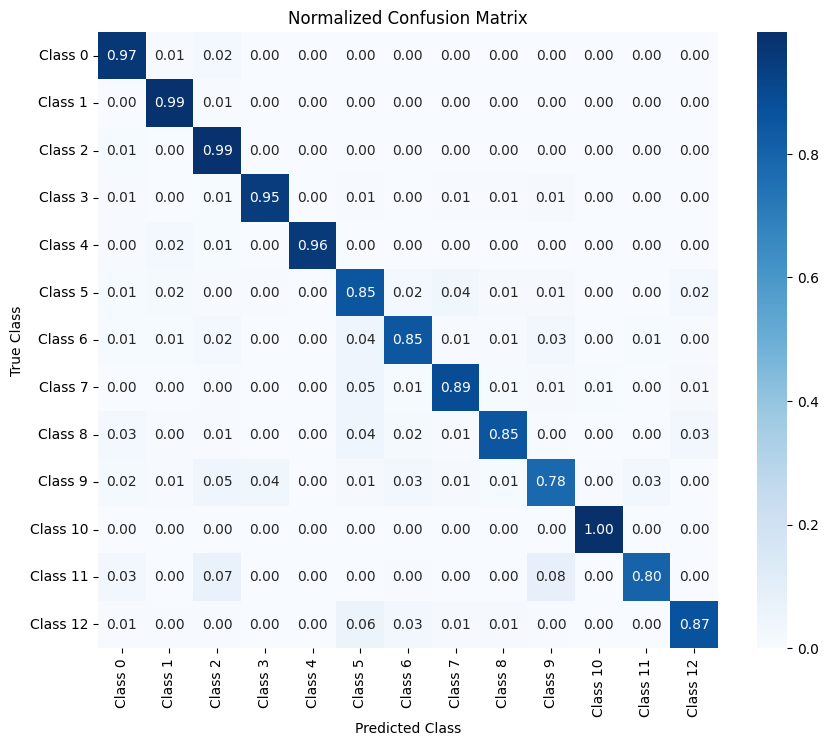

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plots the confusion matrix with labels and a heatmap.
    :param y_true: Ground truth labels
    :param y_pred: Predicted labels
    :param class_names: List of class names (or placeholders)
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

    # Normalize confusion matrix by the number of samples per class
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Normalized Confusion Matrix")
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()

    return cm

# Accumulate true labels and predictions from the test data
y_true = []
y_pred = []

with torch.no_grad():
    for data in test_loader:
        data = {key: value.to(device) for key, value in data.items()}
        outputs = trainer.model(data["bert_input"].float(),
                                data["time"].long(),
                                data["bert_mask"].long())
        preds = outputs.argmax(dim=-1).cpu().numpy()
        labels = data["class_label"].squeeze().cpu().numpy()

        y_true.extend(labels)
        y_pred.extend(preds)

# Generate placeholder class names
num_classes = 13  # Update to match your dataset
class_names = [f"Class {i}" for i in range(num_classes)]

# Plot and get the confusion matrix
conf_matrix = plot_confusion_matrix(y_true, y_pred, class_names)


In [ ]:
def misclassification_analysis(conf_matrix, class_names):
    """
    Analyzes the misclassifications from the confusion matrix.
    :param conf_matrix: The confusion matrix (non-normalized)
    :param class_names: List of class names
    """
    print("\n=== Misclassification Analysis ===")
    for i, class_name in enumerate(class_names):
        true_positives = conf_matrix[i, i]
        false_negatives = conf_matrix[i, :].sum() - true_positives
        false_positives = conf_matrix[:, i].sum() - true_positives

        print(f"\nClass: {class_name}")
        print(f"  True Positives: {true_positives}")
        print(f"  False Negatives: {false_negatives}")
        print(f"  False Positives: {false_positives}")

    most_confused = np.unravel_index(np.argmax(conf_matrix - np.diag(np.diag(conf_matrix))), conf_matrix.shape)
    print(f"\nMost confused classes: {class_names[most_confused[0]]} -> {class_names[most_confused[1]]}")

# Run misclassification analysis
misclassification_analysis(conf_matrix, class_names)



=== Misclassification Analysis ===

Class: Class 0
  True Positives: 3676
  False Negatives: 128
  False Positives: 3735

Class: Class 1
  True Positives: 23996
  False Negatives: 305
  False Positives: 2028

Class: Class 2
  True Positives: 2148
  False Negatives: 32
  False Positives: 7123

Class: Class 3
  True Positives: 13856
  False Negatives: 767
  False Positives: 789

Class: Class 4
  True Positives: 12642
  False Negatives: 550
  False Positives: 358

Class: Class 5
  True Positives: 56630
  False Negatives: 9962
  False Positives: 5905

Class: Class 6
  True Positives: 9950
  False Negatives: 1791
  False Positives: 3687

Class: Class 7
  True Positives: 47798
  False Negatives: 5963
  False Positives: 3580

Class: Class 8
  True Positives: 12210
  False Negatives: 2142
  False Positives: 2104

Class: Class 9
  True Positives: 1299
  False Negatives: 367
  False Positives: 8746

Class: Class 10
  True Positives: 2959
  False Negatives: 9
  False Positives: 661

Class: Class